In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.serialize import model_to_json
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


/Users/joaoandrade/.pyenv/versions/3.12.7/envs/chatbot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/combined_data.csv')
df = df.sort_index()
df.set_index('Date', inplace=True)
df['lag_weekly_sales'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(52)
df.reset_index(inplace=True)
df = df.dropna(subset=['lag_weekly_sales'])


In [3]:
store_data = df[['Date', 'Weekly_Sales', 'Size','Store', 'Dept','MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'week', 'month', 'day', 'lag_weekly_sales', 'IsHoliday']]
store_data.columns = ['ds', 'y', 'Size', 'Store', 'Dept','MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'week', 'month', 'day', 'lag_weekly_sales', 'IsHoliday'] 
regressors = ['Size','Store', 'Dept','MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'week', 'month', 'day', 'lag_weekly_sales']

In [4]:
new_years = pd.DataFrame({
'holiday': 'new_year',
'ds': pd.to_datetime(['2010-12-31', '2011-12-30']),
})
thanksgiving = pd.DataFrame({
'holiday': 'thanksgiving',
'ds': pd.to_datetime(['2010-11-26', '2011-11-25']),
'lower_window': 0,
'upper_window': 0,
})
superbowls = pd.DataFrame({
'holiday': 'superbowl',
'ds': pd.to_datetime(['2010-02-12', '2012-02-10', '2011-02-11']),
'lower_window': 0,
'upper_window': 0,
})
labor_days = pd.DataFrame({
'holiday': 'labor_day',
'ds': pd.to_datetime(['2010-09-10', '2011-09-09', '2012-09-07']),
'lower_window': 0,
'upper_window': 0,
})
holidays = pd.concat((new_years, superbowls, thanksgiving,labor_days))

In [5]:
model = Prophet(holidays=holidays, holidays_prior_scale = 50, weekly_seasonality=True)
model.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='IsHoliday')
model.add_country_holidays(country_name='US')
for regressor in regressors:
    model.add_regressor(regressor)


In [6]:
markDowns = ['MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for markdown in markDowns:
    store_data[markdown].fillna(value=store_data[markdown].mean() , inplace=True) 

/var/folders/8g/hxdrgzwn3hj4nvsz61s8r23m0000gn/T/ipykernel_66292/4080054981.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  store_data[markdown].fillna(value=store_data[markdown].mean() , inplace=True)
/var/folders/8g/hxdrgzwn3hj4nvsz61s8r23m0000gn/T/ipykernel_66292/4080054981.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_data[

In [7]:
train, test = train_test_split(store_data, test_size=0.2, random_state=42)


In [8]:
model.fit(train)


19:45:22 - cmdstanpy - INFO - Chain [1] start processing
19:46:45 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
test = test.sort_values(by='ds', ascending=True)


In [10]:
forecast = model.predict(test)


In [11]:
print(f'R2: {r2_score(test['y'], forecast['yhat'])}')
print(f'MSE : {mean_squared_error(test['y'], forecast['yhat'])}')
print(f'RMSE: {np.sqrt(mean_squared_error(test['y'], forecast['yhat']))}')


R2: 0.9637257348752604
MSE : 19115006.856285512
RMSE: 4372.071231840295


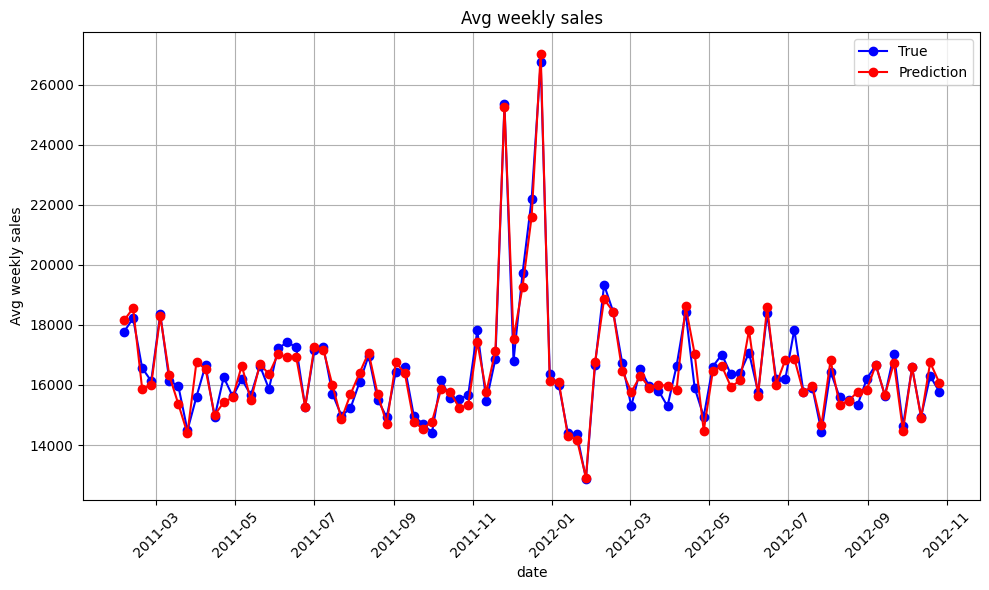

In [12]:
test['ds'] = pd.to_datetime(test['ds'])
df_grouped = test.groupby('ds', as_index=False)['y'].mean()
forecast['ds'] = pd.to_datetime(forecast['ds'])
df_forecast_grouped = forecast.groupby('ds', as_index=False)['yhat'].mean()
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['ds'], df_grouped['y'], marker='o', linestyle='-', color='b')
plt.plot(df_forecast_grouped['ds'], df_forecast_grouped['yhat'], marker='o', linestyle='-', color='r')
plt.title('Avg weekly sales')
plt.xlabel('date')
plt.ylabel('Avg weekly sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(['True', 'Prediction'])
plt.tight_layout()
plt.show()


In [13]:
single_store = store_data[(store_data['Store'] == 5) & (store_data['Dept'] == 1)]
single_store = single_store.sort_values(by='ds', ascending=True)
last_row = single_store.tail(1)
last_date = pd.to_datetime(last_row['ds'].iloc[0])
last_rows = pd.DataFrame({
    'ds': [last_date + pd.DateOffset(weeks=i) for i in range(1, 53)]
})
last_rows = last_rows.join(single_store.tail(52).reset_index(drop=True).drop(columns=['ds']))
result_df = last_rows
result_df = result_df.drop(columns=['y'])

In [14]:
predictions = model.predict(result_df)

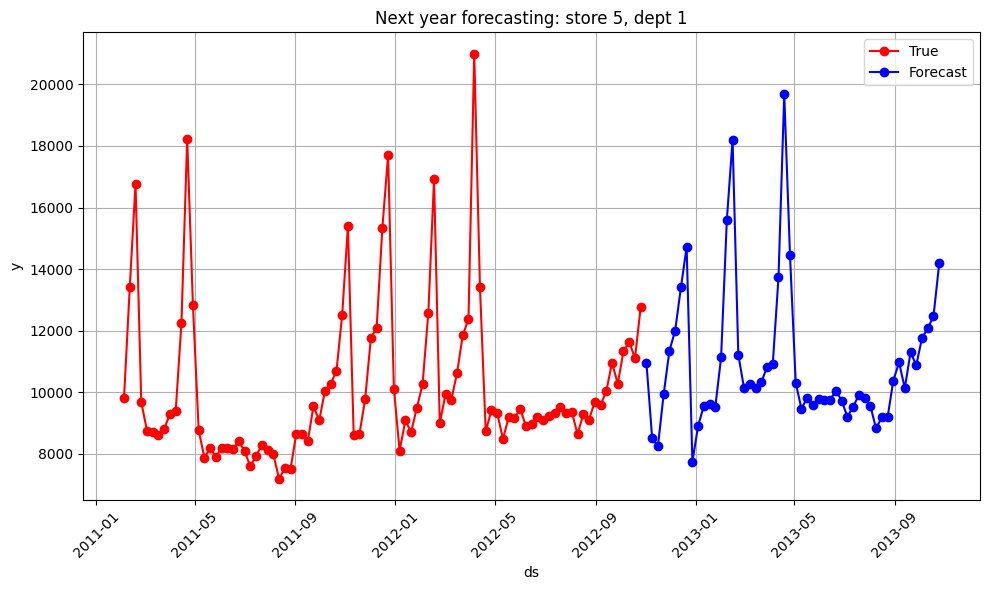

In [15]:
predictions['ds'] = pd.to_datetime(predictions['ds'])
single_store['ds'] = pd.to_datetime(single_store['ds'])
plt.figure(figsize=(10, 6))
plt.plot(single_store['ds'], single_store['y'], marker='o', linestyle='-', color='r')
plt.plot(predictions['ds'], predictions['yhat'], marker='o', linestyle='-', color='b')
plt.title('Next year forecasting: store 5, dept 1')
plt.xlabel('ds')
plt.ylabel('y')
plt.grid(True)
plt.legend(['True', 'Forecast'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
regressor_coef = regressor_coefficients(model)
regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef')

,regressor,regressor_mode,coef
8,week,additive,-105.340525
1,Store,additive,-4.026345
3,MarkDown1,additive,-0.014106
0,Size,additive,0.001797
5,MarkDown3,additive,0.002382
6,MarkDown4,additive,0.011070
4,MarkDown2,additive,0.022294
7,MarkDown5,additive,0.030865
11,lag_weekly_sales,additive,0.988909
2,Dept,additive,11.085666


In [17]:
store_dept_combinations = store_data[['Store', 'Dept']].drop_duplicates()
for _, row in store_dept_combinations.iterrows():
    store, dept = row['Store'], row['Dept']
    single_store = store_data[(store_data['Store'] == store) & (store_data['Dept'] == dept)]
    single_store = single_store.sort_values(by='ds', ascending=True)
    last_row = single_store.tail(1)
    last_date = pd.to_datetime(last_row['ds'].iloc[0])
    last_52_rows = single_store.tail(52).reset_index(drop=True)
    future_rows = pd.DataFrame({
        'ds': [last_date + pd.DateOffset(weeks=i) for i in range(1, 53)]
    })
    
    future_rows = future_rows.join(last_52_rows.drop(columns=['ds']))
    future_rows['lag_weekly_sales'] = future_rows['y']
    future_rows = future_rows.drop(columns=['y'])
    result_df = pd.concat([result_df, future_rows], ignore_index=True)

In [18]:
result_df = result_df.dropna()

In [19]:
result_df = result_df.sort_values(by='ds', ascending=True)


In [20]:
result_df

,ds,Size,Store,Dept,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,week,month,day,lag_weekly_sales,IsHoliday
143572,2011-07-01,158114.0,34.0,58.0,7289.011106,3333.962001,1422.492,3385.573306,4647.335923,8.0,2.0,25.0,2485.00,False
143573,2011-07-08,158114.0,34.0,58.0,7289.011106,3333.962001,1422.492,3385.573306,4647.335923,9.0,3.0,4.0,3260.00,False
143574,2011-07-15,158114.0,34.0,58.0,7289.011106,3333.962001,1422.492,3385.573306,4647.335923,10.0,3.0,11.0,2420.00,False
143575,2011-07-22,158114.0,34.0,58.0,7289.011106,3333.962001,1422.492,3385.573306,4647.335923,11.0,3.0,18.0,2260.22,False
143576,2011-07-29,158114.0,34.0,58.0,7289.011106,3333.962001,1422.492,3385.573306,4647.335923,12.0,3.0,25.0,1465.00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82419,2013-10-25,203819.0,19.0,1.0,5430.750000,90.070000,1422.492,904.340000,1665.770000,43.0,10.0,26.0,33686.67,False
57095,2013-10-25,114533.0,23.0,92.0,4782.750000,124.720000,118.910,1316.960000,738.090000,43.0,10.0,26.0,73499.33,False
9411,2013-10-25,93638.0,29.0,35.0,5581.800000,2.980000,1422.492,398.230000,396.110000,43.0,10.0,26.0,2122.16,False
100983,2013-10-25,155083.0,40.0,32.0,3605.710000,55.980000,0.280,486.810000,1389.060000,43.0,10.0,26.0,4259.24,False


In [21]:
next_year_pred  = model.predict(result_df)

In [22]:
next_year_pred["Store"] = result_df['Store']
next_year_pred["Dept"] = result_df['Dept']
next_year_pred = next_year_pred[['ds','Store', 'Dept', 'yhat']].copy()
next_year_pred.columns = ['date','Store', 'Dept', 'prediction']

In [29]:
next_year_pred.to_csv('prophet_all_stores_prediction.csv')

In [28]:
df_cv = cross_validation(model, initial='365 days', period='15 days', horizon = '180 days')
df_p = performance_metrics(df_cv)


  0%|          | 0/6 [00:00<?, ?it/s]20:02:54 - cmdstanpy - INFO - Chain [1] start processing
20:03:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:43<03:39, 43.83s/it]20:03:37 - cmdstanpy - INFO - Chain [1] start processing
20:04:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [01:32<03:07, 46.80s/it]20:04:27 - cmdstanpy - INFO - Chain [1] start processing
20:04:52 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [02:15<02:14, 44.98s/it]20:05:10 - cmdstanpy - INFO - Chain [1] start processing
20:05:52 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [03:15<01:42, 51.02s/it]20:06:11 - cmdstanpy - INFO - Chain [1] start processing
20:07:01 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [04:24<00:57, 57.53s/it]20:07:20 - cmdstanpy - INFO - Chain [1] start processing
20:08:08 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [05:32<00:00, 55.45s/it]


In [30]:
df_p

,horizon,mse,rmse,mae,mdape,smape,coverage
0,19 days,2.319500e+07,4816.118967,2334.651325,0.169580,0.393393,0.920159
1,20 days,2.297434e+07,4793.155483,2374.699686,0.175444,0.401885,0.919451
2,21 days,2.591041e+07,5090.226808,2456.207488,0.183131,0.406851,0.916516
3,22 days,2.897835e+07,5383.154581,2535.204306,0.184984,0.406520,0.912526
4,23 days,2.703649e+07,5199.662657,2473.721762,0.179488,0.400843,0.914282
...,...,...,...,...,...,...,...
134,175 days,2.213160e+07,4704.422929,3398.891087,0.327483,0.597962,0.991088
135,176 days,2.207456e+07,4698.357146,3402.881522,0.336815,0.596214,0.991196
136,177 days,2.198188e+07,4688.483639,3293.680542,0.310075,0.581259,0.991071
137,178 days,2.355901e+07,4853.762049,3465.425712,0.323088,0.618386,0.991331


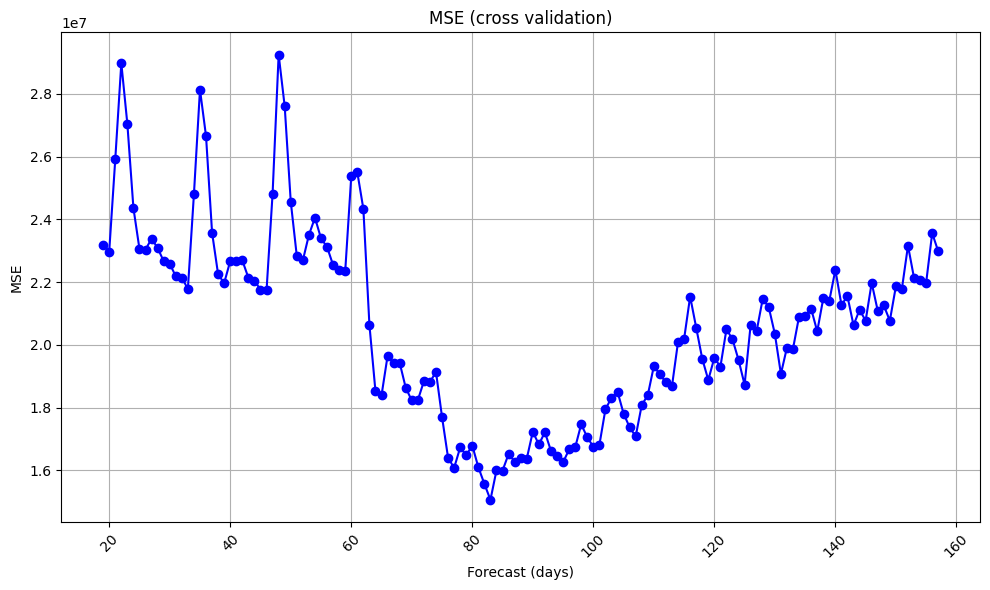

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(df_p.index +19, df_p['mse'], marker='o', linestyle='-', color='b')
plt.title('MSE (cross validation)')
plt.xlabel('Forecast (days)')
plt.ylabel('MSE')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# with open('../src/models/prophet_1_year.json', 'w') as fout:
#     fout.write(model_to_json(model))  
